In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tqdm import tqdm

/Users/tristan/miniconda3/envs/deep/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X = np.array([
    [1,1,1,1,1,1],
    [2,2,2,2,2,2],
    [3,3,3,3,3,3]
])

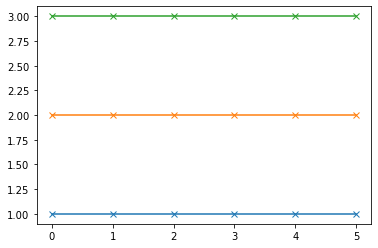

In [3]:
plt.plot(range(6), X[0], marker='x')
plt.plot(range(6), X[1], marker='x')
plt.plot(range(6), X[2], marker='x')
plt.show()

In [4]:
dataset = torch.tensor(X).unsqueeze(1).to(torch.float)
dataset.shape

torch.Size([3, 1, 6])

In [5]:
class Encoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.cnn = nn.Conv1d(1,1,4,1)

    def forward(self, x):
        return F.relu(self.cnn(x))

class Decoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.decoder = nn.ConvTranspose1d(1,1,4,1)
    
    def forward(self,x):
        return F.relu(self.decoder(x))


class TAE(nn.Module):
    def __init__(self, encoder, decoder) -> None:
        super().__init__()
        self.encoder = encoder 
        self.decoder = decoder 

    def forward(self, x):
        l = self.encoder(x)
        x_prime = self.decoder(l)
        return l, x_prime

In [6]:
encoder = Encoder()
decoder = Decoder()
ae = TAE(encoder, decoder)

In [7]:
optimizer = optim.SGD(ae.parameters(), lr=0.05)
criterion = nn.MSELoss()

In [8]:
ls = []

for i in range(25):
    l, x_prime = ae(dataset)
    loss = criterion(x_prime, dataset)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ls.append(l.detach().numpy())
    print(loss.item())


3.9111175537109375
2.1218974590301514
0.7290696501731873
0.5833157896995544
0.4786536395549774
0.39811018109321594
0.3335622549057007
0.28072988986968994
0.2368721216917038
0.20023895800113678
0.16952885687351227
0.14378388226032257
0.12221964448690414
0.10419479012489319
0.08915629982948303
0.07662976533174515
0.06620277464389801
0.05752114951610565
0.05028238892555237
0.044231489300727844
0.039155662059783936
0.034879401326179504
0.03125888854265213
0.028177082538604736
0.025539085268974304


In [9]:
ls = [i.squeeze(1) for i in ls]

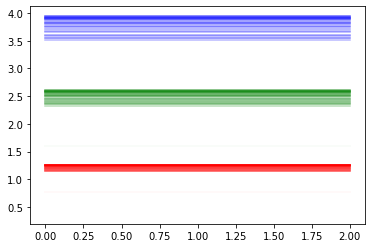

In [10]:
for i in range(25):
    for j in range(3):
        plt.plot(range(3), ls[i][0], c='r', alpha=i * 0.01)
        plt.plot(range(3), ls[i][1], c='g', alpha=i * 0.01)
        plt.plot(range(3), ls[i][2], c='b', alpha=i * 0.01)

In [11]:
l, x_prime = ae(dataset)

In [12]:
centroids = np.array([
    [-1,-1,-1],
    [2,2,2],
    [5,5,5]
])

In [13]:
centroids = torch.tensor(centroids).unsqueeze(1).to(torch.float)
centroids.shape

torch.Size([3, 1, 3])

In [14]:
# for i in range(25):
#     for j in range(3):
#         plt.plot(range(3), ls[i][0], c='r', alpha=i * 0.01)
#         plt.plot(range(3), ls[i][1], c='g', alpha=i * 0.01)
#         plt.plot(range(3), ls[i][2], c='b', alpha=i * 0.01)

# plt.plot(range(3), centroids[0], c='black')
# plt.plot(range(3), centroids[1], c='black')
# plt.plot(range(3), centroids[2], c='black')
# plt.show()

In [15]:
class ClusterLayer(nn.Module):
    def __init__(self, encoder, centroids) -> None:
        super().__init__()
        self.encoder = encoder 
        self.centroids = nn.Parameter(centroids)
    
    def euclidean_distance(self, x, y):
        dists = torch.zeros(3,3)

        for i in range(3):
            d = []
            for j in range(3):
                a = x[i].flatten()
                b = y[j].flatten()
                euc = ((a-b)**2).sum()
                dists[i][j] = euc
        return dists

    def students_t_distribution_kernel(self, x, alpha=1):
        num = torch.pow((1 + x / alpha), -(alpha + 1) / 2)
        denom = num.sum(dim=1).reshape(-1, 1).repeat(1, 3)
        return num / denom

    def target_distribution(self, Q):
        F = Q.sum(dim=0)
        num = (Q ** 2) / F
        denom = num.sum(dim=1).reshape(-1, 1).repeat(1, Q.shape[-1])
        return num / denom

    def forward(self, x):
        l = self.encoder(x)
        D = self.euclidean_distance(l, self.centroids)
        Q = self.students_t_distribution_kernel(D)
        P = self.target_distribution(Q)
        return l, torch.log(Q), torch.log(P)

In [16]:
cl = ClusterLayer(encoder=encoder, centroids=centroids)

In [17]:
optimizer = optim.SGD(cl.parameters(), lr=0.001)
mse = nn.MSELoss()
kl = nn.KLDivLoss(reduction='batchmean', log_target=True)

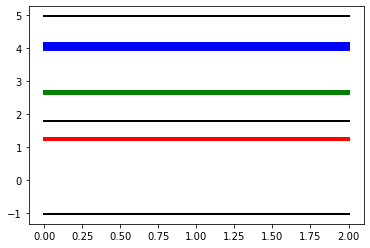

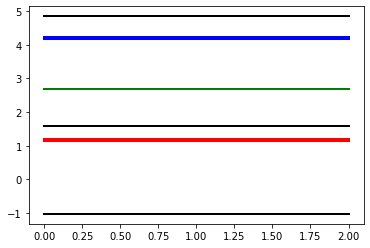

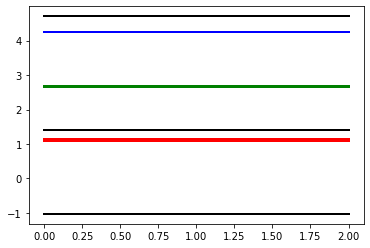

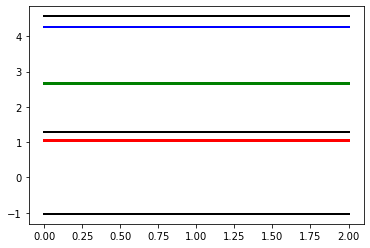

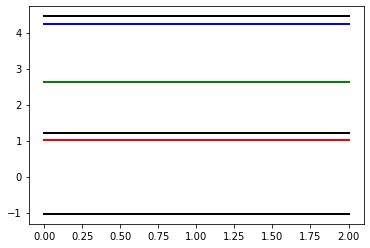

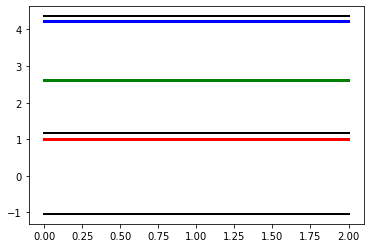

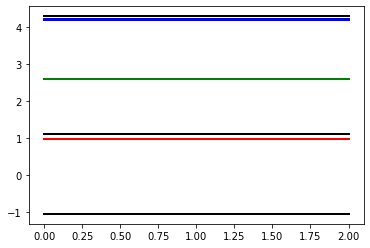

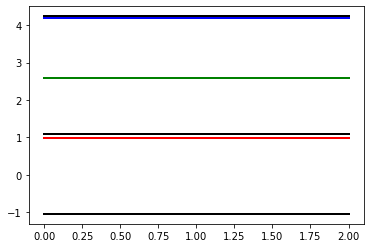

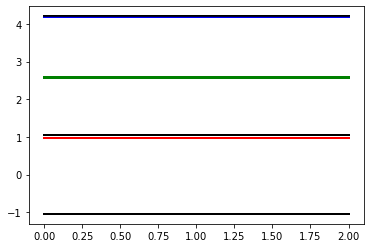

In [18]:
mse_data = []
kl_data = []
ls = []
cents = []

for i in range(100000):
    l, P, Q = cl(dataset)
    x_prime = decoder(l)

    mse_loss = mse(dataset, x_prime)
    kl_loss = kl(Q, P)

    dtc_loss = mse_loss +  kl_loss

    optimizer.zero_grad()
    dtc_loss.backward()
    optimizer.step()

    mse_data.append(mse_loss.item())
    kl_data.append(kl_loss.item())

    if i % 100 == 0:
        ls.append(l)
        cents.append(cl.centroids)

    if i % 10000 == 0:
        if i  == 0:
            continue
        ls = [i.squeeze(1).detach() for i in ls]
        cents = [i.squeeze(1).detach() for i in cents]

        for i in range(len(ls)):
            for j in range(3):
                plt.plot(range(3), ls[i][0], c='r')#, alpha=i * 0.01)
                plt.plot(range(3), ls[i][1], c='g')#, alpha=i * 0.01)
                plt.plot(range(3), ls[i][2], c='b')#, alpha=i * 0.01)
                plt.plot(range(3), cents[i][0], c='black')#, alpha=i * 0.01)
                plt.plot(range(3), cents[i][1], c='black')#, alpha=i * 0.01)
                plt.plot(range(3), cents[i][2], c='black')#, alpha=i * 0.01)

        plt.show()

        ls = []
        cents = []


In [ ]:
plt.plot(range(len(mse_data)), mse_data)
plt.show()

In [ ]:
plt.plot(range(len(kl_data)), kl_data)
plt.show()

In [ ]:
ls = [i.squeeze(1).detach() for i in ls]
cents = [i.squeeze(1).detach() for i in cents]

In [ ]:
for i in range(len(ls)):
    for j in range(3):
        plt.plot(range(3), ls[i][0], c='r')#, alpha=i * 0.01)
        plt.plot(range(3), ls[i][1], c='g')#, alpha=i * 0.01)
        plt.plot(range(3), ls[i][2], c='b')#, alpha=i * 0.01)
        plt.plot(range(3), cents[i][0], c='black')#, alpha=i * 0.01)
        plt.plot(range(3), cents[i][1], c='black')#, alpha=i * 0.01)
        plt.plot(range(3), cents[i][2], c='black')#, alpha=i * 0.01)

In [ ]:
ls